# Visualize the Results of SpatioCell

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import json
from pathlib import Path
import tarfile

In [2]:
def make_targz(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=Path(source_dir).name)

    return

## Load data

In [3]:
image_file = './CytAssist_FFPE_Human_Lung_Squamous_Cell_Carcinoma_tissue_image.tif'
nuclei_seg_json_file = './CytAssist_FFPE_Human_Lung_Squamous_Cell_Carcinoma_tissue_image.json'
cell_info_file = './outs/cell_info.json'

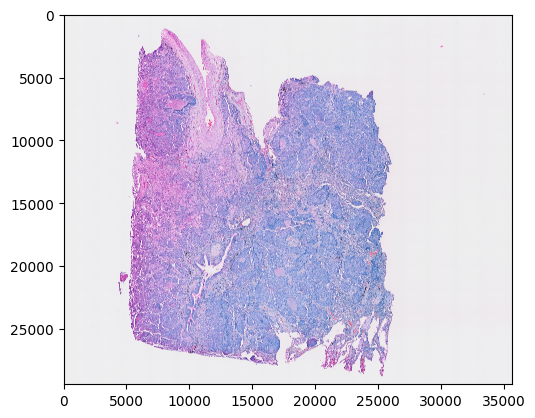

In [4]:
# cv2
image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
with open(nuclei_seg_json_file, 'r') as f:
    nuclei_seg = json.load(f)
with open(cell_info_file, 'r') as f:
    cell_info = json.load(f)

plt.imshow(image)
plt.show()

## Plot

In [ ]:
mask_assigned = np.full(image.shape, 255, dtype=np.uint8)
mask_guessed = np.full(image.shape, 255, dtype=np.uint8)
mask_gt = np.full(image.shape, 255, dtype=np.uint8)
mask_alpha = np.full(image.shape[: 2], 0, dtype=np.uint8)

seg_colors = {'Neo': (255, 0, 0), 'Conn': (0, 255, 0), 'Inflam': (255, 255, 0), 'Dead': (0, 255, 255), 'Epi': (255, 0, 255)}

assigned_color = {
    "B cell": (255, 82, 82),
    "Plasma cell": (255, 128, 171),
    "T cell": (224, 64, 251),
    "NK cell": (255, 171, 64),
    "Mast cell": (255, 64, 129),
    "Macrophage/Monocyte": (197, 17, 98),
    'Neutrophil': (170, 0, 255),
    "DC": (83, 109, 254),
    "Endothelial cell": (124, 77, 255),
    "Epithelial cell": (24, 255, 255),
    "Cancer cell": (118, 255, 3),
    "Stromal": (255, 255, 0),
    "unassigned type": (169, 169, 169),
    "Dead": (169, 169, 169),
}

line_width = -1
outline = False
outline_width = 15
outline_alpha = 0.4

for minor_type in tqdm(assigned_color.keys()):
    assigned_contours = [np.array(nuclei_seg['nuc'][i]['contour']) for i in cell_info.keys() if cell_info[i]['assign'] == minor_type]
    guessed_contours = [np.array(nuclei_seg['nuc'][i]['contour']) for i in cell_info.keys() if cell_info[i]['random_guess'] == minor_type]
    gt_contours = [np.array(nuclei_seg['nuc'][i]['contour']) for i in cell_info.keys() if cell_info[i]['gt'] == minor_type]

    cv2.drawContours(mask_assigned, assigned_contours, -1, assigned_color[minor_type], line_width)
    cv2.drawContours(mask_guessed, guessed_contours, -1, assigned_color[minor_type], line_width)
    cv2.drawContours(mask_gt, gt_contours, -1, assigned_color[minor_type], line_width)
    cv2.drawContours(mask_alpha, assigned_contours, -1, 255, line_width)

    if outline:
        mask_assigned = outline(mask_assigned, assigned_contours, assigned_color[minor_type], outline_width)
        mask_guessed = outline(mask_guessed, guessed_contours, assigned_color[minor_type], outline_width)
        mask_gt = outline(mask_gt, gt_contours, assigned_color[minor_type], outline_width)
        mask_alpha = outline(mask_alpha, assigned_contours, round(255 * outline_alpha), outline_width)

mask_assigned = cv2.cvtColor(mask_assigned, cv2.COLOR_RGB2RGBA)
mask_guessed = cv2.cvtColor(mask_guessed, cv2.COLOR_RGB2RGBA)
mask_gt = cv2.cvtColor(mask_gt, cv2.COLOR_RGB2RGBA)
mask_assigned[..., 3] = mask_alpha
mask_guessed[..., 3] = mask_alpha
mask_gt[..., 3] = mask_alpha

plt.imshow(mask_assigned)
plt.show()

100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


## Save

In [ ]:
save_dir = './outs/view/'

image_resized = cv2.resize(image, fx=0.5, fy=0.5, dsize=(0, 0))
mask_assigned_resized = cv2.resize(mask_assigned, fx=0.5, fy=0.5, dsize=(0, 0))
mask_guessed_resized = cv2.resize(mask_guessed, fx=0.5, fy=0.5, dsize=(0, 0))
mask_gt_resized = cv2.resize(mask_gt, fx=0.5, fy=0.5, dsize=(0, 0))

Path(save_dir).mkdir(parents=True, exist_ok=True)
cv2.imwrite('%s/image_resized.png' % save_dir, cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR))
cv2.imwrite('%s/assigned_mask_resized.png' % save_dir, cv2.cvtColor(mask_assigned_resized, cv2.COLOR_RGBA2BGRA))
cv2.imwrite('%s/guessed_mask_resized.png' % save_dir, cv2.cvtColor(mask_guessed_resized, cv2.COLOR_RGBA2BGRA))
cv2.imwrite('%s/gt_mask_resized.png' % save_dir, cv2.cvtColor(mask_gt_resized, cv2.COLOR_RGBA2BGRA))

make_targz('%s/%s.tar.gz' % (Path(save_dir).parent, Path(save_dir).name), save_dir)